# Machine Learning Engineer Nanodegree
## Capstone Project
Ian Gregson
September 22nd 2018

# 1. Definition

### Project Overview

In this section, look to provide a high-level overview of the project in layman’s terms. Questions to ask yourself when writing this section:
- _Has an overview of the project been provided, such as the problem domain, project origin, and related datasets or input data?_
- _Has enough background information been given so that an uninformed reader would understand the problem domain and following problem statement?_


The domain background for this project is that it comes directly from my work for a startup that is building a customer data platform that helps users maximize their account based recurring revenue. In this field, BizOps profressional leverage large quantities of data from multiple sources such as CRMs or customer engagement analytics tools. The platform we build collates thiss data to provide a single view of an account (a non trivial problem in this space) but much of the insights that are gleaned from this large quantity of data come from the judgements of BizOps professionals studying the data.

The project seeks to take steps into a new way of deriving insights from this large suite of structured data. By automating some aspects of the data analysis with machine learning models will free up the professionals to apply their extensive domain expertise in solving new problems.

I have a personal motivation in undertaking this project because I want to help push my team to become leaders in our field.

### Problem Statement

In this section, you will want to clearly define the problem that you are trying to solve, including the strategy (outline of tasks) you will use to achieve the desired solution. You should also thoroughly discuss what the intended solution will be for this problem. Questions to ask yourself when writing this section:
- _Is the problem statement clearly defined? Will the reader understand what you are expecting to solve?_
- _Have you thoroughly discussed how you will attempt to solve the problem?_
- _Is an anticipated solution clearly defined? Will the reader understand what results you are looking for?_


The problem to be solved in this project is the problem of opportunity scoring. There is historical data that shows which opportunities eventually convert to become accounts with annually recurring revenue. BizOps practitioners will use this historical data to make judgements on what active oppoortunities are most likely to convert by comparing their features with the features of examples from the historical data.

This project seeks to build a machine learning model that will make these judgements.

To build that model, this project will work through the following steps:

* Establish and prepare evaluation metrics
* Explore the dataset and establish necessary pre-processing steps
* Establish a benchmark using a dummy classifier
* Carry out pre-processing of the dataset
* Implement a number of models using grid search to establish the best hyperparameters
* Train and validate the models on the dataset
* Refine the model that looks to have the best performance
* Evaluate the performance of the model on the dataset against the benchmark and establish whether or not the model is viable for further use

The model will be deemed acceptable for furhter use if the predictions it makes are better than those returned by the dummy classifier.


### Metrics

In this section, you will need to clearly define the metrics or calculations you will use to measure performance of a model or result in your project. These calculations and metrics should be justified based on the characteristics of the problem and problem domain. Questions to ask yourself when writing this section:
- _Are the metrics you’ve chosen to measure the performance of your models clearly discussed and defined?_
- _Have you provided reasonable justification for the metrics chosen based on the problem and solution?_


Since this project aims to solve a classification problem, I expect the F1 Score metric will provide suitable evaluation of the performance of the benchmark and solution models.

The F1 Score will provide a numeric means of judging the performance that can help more definiteively assess the performance of final model and ascertain whether or not it can be used further for opportunity scoring. The F1 Score metric should help give a good balance between _recall_ and _precision_ since it is unlikely the dataset will have an equal of number of samples in each of the two classes.

## 2. Analysis

### Data Exploration

In this section, you will be expected to analyze the data you are using for the problem. This data can either be in the form of a dataset (or datasets), input data (or input files), or even an environment. The type of data should be thoroughly described and, if possible, have basic statistics and information presented (such as discussion of input features or defining characteristics about the input or environment). Any abnormalities or interesting qualities about the data that may need to be addressed have been identified (such as features that need to be transformed or the possibility of outliers). Questions to ask yourself when writing this section:
- _If a dataset is present for this problem, have you thoroughly discussed certain features about the dataset? Has a data sample been provided to the reader?_
- _If a dataset is present for this problem, are statistics about the dataset calculated and reported? Have any relevant results from this calculation been discussed?_
- _If a dataset is **not** present for this problem, has discussion been made about the input space or input data for your problem?_
- _Are there any abnormalities or characteristics about the input space or dataset that need to be addressed? (categorical variables, missing values, outliers, etc.)_



In [1]:
# Let's load up our std libraries and start having some fun

import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Set up some necessary constants
RANDOM_SEED = 42
K_FOLDS = 10

In [78]:
raw_opportunities_data = pd.read_csv('data/csv/DataStore_query-1536516138031.json.csv', low_memory=False)
display(raw_opportunities_data.sample(5))
print('There are {} rows and {} columns in the dataset.'.format(raw_opportunities_data.shape[0], raw_opportunities_data.shape[1]))

,Labels,Name,CreatedDate,CloseDate,Amount,StageName,Probability,Type,AccountId,Account_Region__c,...,What_will_developers_need_to_succeed__c,Who_cares_about_it__c,Who_is_leading_the_sale__c,Who_is_the_competition__c,Who_needs_to_be_convinced_of_what_for_se__c,Why_does_this_opp_merit_more_investment__c,Why_should_the_customer_change__c,Why_should_they_work_with_MuleSoft__c,Winning_Competitor__c,Id.1
4560,0063400001BxeAnAAJ,Defence Health-Transformation,2018-06-15 04:31:08,2019-04-26,83057.00,1. ID Business Initiative,10.0,New Business,0013400001QpRubAAF,ANZ,...,NaN,The board,NaN,Mule ESB Community;Microsoft;Custom Application,NaN,"Currently undergoing, complete transformation",NaN,NaN,NaN,0063400001BxeAnAAJ
3763,0063400001CCo6nAAD,Schneider Electric- SF Lead pass 2,2018-07-10 15:51:51,2018-09-30,1.00,0. Sales Qualified Lead,0.0,New Business,0018000000lrscfAAA,SE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0063400001CCo6nAAD
5126,0063400001CTbHAAA1,Belk - legacy mod - Platform,2018-07-26 19:45:54,2019-01-18,157857.00,1. ID Business Initiative,10.0,New Business,00180000016dRHgAAM,South,...,NaN,NaN,NaN,NaN,NaN,legcay mod initiaitve��<br><br>large spend on ...,NaN,NaN,NaN,0063400001CTbHAAA1
4850,0063400001ByIuiAAF,Cadillac Fairview - Anypoint - 2019 Renewal,2018-06-21 21:02:57,2019-06-29,104906.41,1. Waiting to contact,75.0,Renewal,0018000001C8A5QAAV,North,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0063400001ByIuiAAF
2336,0063400001CTkNjAAL,Training,2018-08-03 13:49:22,2018-08-15,11238.75,Closed Won,100.0,Add-On Business,0018000000dfvKiAAI,East,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0063400001CTkNjAAL


There are 5809 rows and 471 columns in the dataset.


In [81]:
# naively get stats
raw_opportunities_data.describe()

,Amount,Probability,Actions_Since_Last_Week__c,Actual_Launch_Date__c,ACV__c,Additional_SC_notes__c,Add_On_Business_Subscription__c,Any_outstanding_issues__c,Anypoint_Username__c,Application_Server_s__c,...,TargetInstallationDate__c,Target_Launch_Date__c,The_Power_of_One__c,Total_List_Discount__c,Total_List_Price__c,Training_Amount__c,Uploaded_Evidence_of_Delivery_to_Account__c,Value_MuleSoft_generates__c,Weighted_ACV_Amount__c,Weighted_Services_Amount__c
count,5.260000e+03,5809.000000,0.0,0.0,5.809000e+03,0.0,1.521000e+03,0.0,0.0,0.0,...,0.0,0.0,5809.0,4.477000e+03,5.809000e+03,5809.000000,0.0,4.800000e+01,5.809000e+03,5809.000000
mean,1.325405e+05,35.610432,NaN,NaN,7.524562e+04,NaN,7.924366e+04,NaN,NaN,NaN,...,NaN,NaN,1.0,-4.286222e+05,1.213588e+05,756.935457,NaN,7.109516e+06,1.356769e+04,5237.646486
std,2.277824e+05,39.285070,NaN,NaN,1.296853e+05,NaN,1.767058e+05,NaN,NaN,NaN,...,NaN,NaN,0.0,1.338227e+07,2.942839e+05,5201.057655,NaN,1.315392e+07,4.939383e+04,27154.648216
min,-1.425722e+06,0.000000,NaN,NaN,-1.115921e+06,NaN,0.000000e+00,NaN,NaN,NaN,...,NaN,NaN,1.0,-5.249999e+08,-1.114850e+05,0.000000,NaN,2.079070e+05,-1.115921e+06,-309801.600000
25%,1.800000e+04,0.000000,NaN,NaN,0.000000e+00,NaN,0.000000e+00,NaN,NaN,NaN,...,NaN,NaN,1.0,-1.000000e+00,1.500000e+03,0.000000,NaN,3.000000e+06,0.000000e+00,0.000000
50%,8.305700e+04,10.000000,NaN,NaN,1.710000e+04,NaN,2.311282e+04,NaN,NaN,NaN,...,NaN,NaN,1.0,0.000000e+00,8.305700e+04,0.000000,NaN,4.639848e+06,0.000000e+00,0.000000
75%,1.711035e+05,75.000000,NaN,NaN,1.150000e+05,NaN,8.550000e+04,NaN,NaN,NaN,...,NaN,NaN,1.0,2.000000e+01,1.578570e+05,0.000000,NaN,6.800000e+06,1.401503e+04,0.000000
max,5.250000e+06,100.000000,NaN,NaN,2.500000e+06,NaN,2.500000e+06,NaN,NaN,NaN,...,NaN,NaN,1.0,5.940000e+02,1.152074e+07,166725.000000,NaN,6.800000e+07,1.500525e+06,562400.000000


It appears the dataset contains a number of cells that are NaN or a data type that is unsuitable for using in an ML model. These will need to be removed during the project's data preprocessing step.

While this will reduce the number of features to an extent, once the remaining features are vectorized it is likely the total number will grow very large. To combat this, a feature selection step should be included during data preprocessing.

,Data type,Count
0,bool,54
1,int64,2
2,float64,164
3,object,251


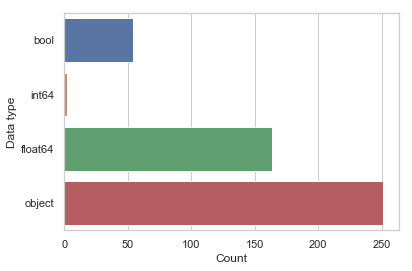

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

data_types = raw_opportunities_data.columns.to_series().groupby(raw_opportunities_data.dtypes).groups
data_types_list = []

for t in data_types:
    data_types_list.append([str(t), len(data_types[t])])

data_types = pd.DataFrame(data_types_list, columns=['Data type','Count'])
display(data_types)
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
sns.barplot(x="Count", y="Data type", data=data_types)

Of the 471 columns in the dataset, most are of the `object` data type. A number of these columns are most likely not useful and visual inspection of the data will be necessary to establish which of these categorical features need to be dropped from the dataset. The rest of the `boolean` and `object` type categorical features will then be vectorized before they go forward into feature selection.

In [108]:
raw_opportunities_data.isnull().any()

Labels                                         False
Name                                           False
CreatedDate                                    False
CloseDate                                      False
Amount                                          True
StageName                                      False
Probability                                    False
Type                                            True
AccountId                                      False
Account_Region__c                               True
Account_Theater__c                              True
Actions_Next_Week_with_Owners__c                True
Actions_Owners__c                               True
Actions_Since_Last_Week__c                      True
Actual_Launch_Date__c                           True
ACV__c                                         False
Add_Billing_Contact__c                         False
Added_Billing_Address__c                       False
Added_Product_Dates__c                        

There are a large number of columns with `null` values. If a feature has too many `null` values, it will not be useful to the final model and will be dropped. Otherwise, the `null` values will be filled using Pandas' `.fillna` method.

,StageName
count,5809
unique,16
top,1. ID Business Initiative
freq,1332


,StageName
4154,Closed Lost
5745,1. ID Business Initiative
3356,1. Waiting to contact
1924,Closed Won
2833,2. Educate on MuleSoft Vision
2324,0. Sales Qualified Lead
583,Closed Won
2676,1. ID Business Initiative
4572,Closed Won
2007,4. Validate Solution


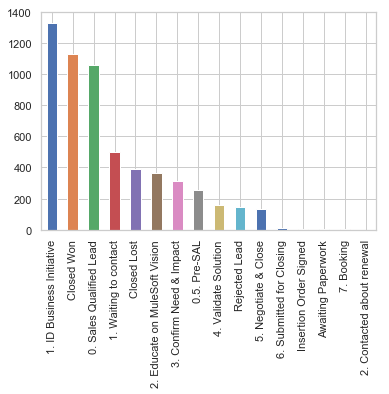

In [75]:
display(raw_opportunities_data[['StageName']].describe())
display(raw_opportunities_data[['StageName']].sample(10))
pd.value_counts(raw_opportunities_data['StageName']).plot.bar()

`StageName` is the label that this project is concerned with. As the graph shows, there are many different stage to which an opportunity can belong. This project is only concerned with two categories: 'Closed Won' and 'Closed Lost'. The dataset will be filtered to only include rows that have either of these labels.

It is also clear from the above graph that there are many more `Closed Won` samples than `Closed Lost`. This makes it all the more important that randomized test and validation slices are taken from the input data when training models. It will also be important to keep this in mind when assessing performance of the model: the uneven number of samples in each class anticipates a that a model could find _recall_ success but suffer from a high rate of false positives/negatives.

### TODO :: Exploratory Visualization

In this section, you will need to provide some form of visualization that summarizes or extracts a relevant characteristic or feature about the data. The visualization should adequately support the data being used. Discuss why this visualization was chosen and how it is relevant. Questions to ask yourself when writing this section:
- _Have you visualized a relevant characteristic or feature about the dataset or input data?_
- _Is the visualization thoroughly analyzed and discussed?_
- _If a plot is provided, are the axes, title, and datum clearly defined?_


### Algorithms and Techniques

In this section, you will need to discuss the algorithms and techniques you intend to use for solving the problem. You should justify the use of each one based on the characteristics of the problem and the problem domain. Questions to ask yourself when writing this section:
- _Are the algorithms you will use, including any default variables/parameters in the project clearly defined?_
- _Are the techniques to be used thoroughly discussed and justified?_
- _Is it made clear how the input data or datasets will be handled by the algorithms and techniques chosen?_


A number of algorithms will be employed in this project:

**Pandas**

* `.dropna()`
* `.fillna()`

These utilities are used to remove null samples from the dataset.

**Utilities**

* `make_scorer`
* `DummyClassifier`
* `DictVectorizer`
* `LabelEncoder`
* `MaxAbsScaler`
* `SelectKBest`
* `train_test_split`
* `Kfold`
* `cross_val_score`
* `GridSearchCV`

**Classifiers**

* `LogisticRegression`
* `GaussianNB`
* `KNeighborsClassifier`
* `SVC`
* `RandomForestClassifier`
* `lgb.sklearn.LGBMClassifier`
* `xgb.XGBClassifier`

Each classifier is employed at first with it's default configuration i.e. no parameters are passed to the constructor. Each of these models are tested with k-fold cross validation scored with the **f1 score** metric. The classifier that performs best in this pass will then be reconfigured with hyper-parameters using `GridSearchCV`.

### Benchmark

In this section, you will need to provide a clearly defined benchmark result or threshold for comparing across performances obtained by your solution. The reasoning behind the benchmark (in the case where it is not an established result) should be discussed. Questions to ask yourself when writing this section:
- _Has some result or value been provided that acts as a benchmark for measuring performance?_
- _Is it clear how this result or value was obtained (whether by data or by hypothesis)?_


For the purposes of this project, it is sufficient to build a model that is demonstrably better than a guess. Thus, it is sufficient to use sci-kit learn's dummy classifier to build a fake model. Then, the performance of this dummy model will be measured using the same metric (**f1 score**) as will be used to asses the final model.

The mean (**f1 score**) of the cross validated dummy classifier then gives a benchmark against which to judge the final model.

In [2]:
# Let's load up our std libraries and start having some fun

import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import utils
%matplotlib inline

# Set up some necessary constants
SPLIT_RANDOM_SEED = 42
DCLF_RANDOM_SEED = 42
K_FOLD_RANDOM_SEED = 3
K_FOLDS = 5
K_FEATURES = 200
NA_THRESHOLD = 0.975
LABEL_COLUMN = 'StageName'

#### Metrics

In [3]:
#  Set up a scoring function that uses the f1 score metric
from sklearn.metrics import f1_score, make_scorer
f1_scorer = make_scorer(f1_score)

#### Dummy Classifier

In [4]:
#  Set up the dummy classifier
from sklearn.dummy import DummyClassifier
dclf = DummyClassifier(random_state=DCLF_RANDOM_SEED)

#### Benchmark

In [9]:
# First up, load the raw dataset
raw_data = pd.read_csv('data/csv/DataStore_query-1536516138031.json.csv', low_memory=False)

# Drop rows with labels that are not relevant and separate features from labels
data = utils.drop_rows(raw_data)
labels = utils.get_labels(data, label_column=LABEL_COLUMN)
features = data.drop(columns=[LABEL_COLUMN], axis=1)
features = utils.drop_na_columns(features, label_column=LABEL_COLUMN, na_threshold=NA_THRESHOLD)

# Columns that are deemed to be of no worth or are direct proxies for the label columns
cols_to_remove = [
    'Labels',
    'Name',
    'CreatedDate',
    'CloseDate',
    'Probability',
    'AccountId',
    'ACV__c',
    'CreatedById',
    'Created_Date_30_day_lookback__c',
    'CurrencyIsoCode',
    'DM_Close_Type__c',
    'DM_Won_Amount__c',
    'ExpectedRevenue',
    'forecast__c',
    'ForecastCategory',
    'ForecastCategoryName',
    'Id',
    'LastModifiedById',
    'mkto_si__MarketoAnalyzer__c',
    'Opportunity_ID_18_digit__c',
    'Opportunity_Owner_ID_18_digit__c',
    'Original_Quote__c',
    'OwnerId',
    'Pricebook2Id',
    'RecordTypeId',
    'Renewal_Forecast_Amount__c',
    'Stage__c',
    'Stage_Choices__c',
    'Strategy_Choices__c',
    'Id.1',
    'Metric_Price2Close__c',
    'IsWon'
]

features = features.drop(columns=cols_to_remove, axis=1)
features = utils.encode(features)

# One hot encode categorical features
features = utils.encode(features)

# Train test split
X_train, X_test, y_train, y_test = utils.data_split(features, labels, random_state=SPLIT_RANDOM_SEED)

# Feature scaling
from sklearn.preprocessing import MaxAbsScaler

max_abs_scaler = MaxAbsScaler()
X_train = max_abs_scaler.fit_transform(X_train)
X_test = max_abs_scaler.fit_transform(X_test)

# Feature selection
X_train = utils.feature_selection(X_train, y_train, K_FEATURES)

# Score the dummy classifier
from sklearn import model_selection
kfold = model_selection.KFold(n_splits=K_FOLDS, random_state=K_FOLD_RANDOM_SEED)
cv_results = model_selection.cross_val_score(dclf, X_train, y_train, cv=kfold, scoring=f1_scorer)
display('Mean f1_score from KFold cross validation {:0.2f}'.format(cv_results.mean()))

'Mean f1_score from KFold cross validation 0.73'

The DummyClassifier achieves an average of **f1 score** 73%. This establishes a baseline for assessing the success of the final modal. Given the dataset, a guess could be expected to be accurate in 73% of predictions. In order to demonstrate that the final model built in the project is better than a guess, it must a achieve a better average f1 score than 73%.

## 3. Methodolgy

### Data Preprocessing

In this section, all of your preprocessing steps will need to be clearly documented, if any were necessary. From the previous section, any of the abnormalities or characteristics that you identified about the dataset will be addressed and corrected here. Questions to ask yourself when writing this section:
- _If the algorithms chosen require preprocessing steps like feature selection or feature transformations, have they been properly documented?_
- _Based on the **Data Exploration** section, if there were abnormalities or characteristics that needed to be addressed, have they been properly corrected?_
- _If no preprocessing is needed, has it been made clear why?_


A number of preprocessing steps will be required in order to ready the data for use in training a model. These steps are as follows:

* Load the raw dataset
* Filter the samples down to only those that include the labels that are useful for purposes here: `Closed won` and `Closed lost`
* Separate the labels column from the features and encode them
* Drop columns that have too many rows without a value and backfill the remain the columns
* Make a visual inspection of the remaining columns
* Drop a number of columns by name that are known to be of no use or are a direct proxy for the label column
* Make a list of the categorical features in the dataset and One Hot Encode them
* Write the processed dataset to CSV and make a final inspection

In [2]:
# Let's load up our std libraries and start having some fun

import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import utils
%matplotlib inline

# Set up some necessary constants
SPLIT_RANDOM_SEED = 42
K_FOLD_RANDOM_SEED = 3
K_FOLDS = 5
K_FEATURES = 200
NA_THRESHOLD = 0.975
LABEL_COLUMN = 'StageName'

#### Load the raw dataset

In [6]:
# First up, load the raw dataset
raw_data = pd.read_csv('data/csv/DataStore_query-1536516138031.json.csv', low_memory=False)
display(raw_data.shape)

(5809, 471)

#### Filter the samples down to only those that include the labels that are useful for purposes here: `Closed won` and `Closed lost`

In [7]:
data = utils.drop_rows(raw_data)
display(data.shape)

(1519, 471)

#### Separate the labels column from the features and encode them

In [8]:
labels = utils.get_labels(data, label_column=LABEL_COLUMN)
features = data.drop(columns=[LABEL_COLUMN], axis=1)
display(features.shape)
display(labels.shape)

(1519, 470)

(1519,)

#### Drop columns that have too many rows without a value and backfill the remain the columns

In [9]:
features = utils.drop_na_columns(features, label_column=LABEL_COLUMN, na_threshold=NA_THRESHOLD)
display(features.shape)

(1519, 132)

#### Make a visual inspection of the remaining columns

In [10]:
data = features
data['labels'] = labels
data.to_csv('data/csv/preview_data.csv', index=False)

In [11]:
# Columns that are deemed to be of no worth or are direct proxies for the label columns
cols_to_remove = [
    'Labels',
    'Name',
    'CreatedDate',
    'CloseDate',
    'Probability',
    'AccountId',
    'ACV__c',
    'CreatedById',
    'Created_Date_30_day_lookback__c',
    'CurrencyIsoCode',
    'DM_Close_Type__c',
    'DM_Won_Amount__c',
    'ExpectedRevenue',
    'forecast__c',
    'ForecastCategory',
    'ForecastCategoryName',
    'Id',
    'LastModifiedById',
    'mkto_si__MarketoAnalyzer__c',
    'Opportunity_ID_18_digit__c',
    'Opportunity_Owner_ID_18_digit__c',
    'Original_Quote__c',
    'OwnerId',
    'Pricebook2Id',
    'RecordTypeId',
    'Renewal_Forecast_Amount__c',
    'Stage__c',
    'Stage_Choices__c',
    'Strategy_Choices__c',
    'Id.1',
    'Metric_Price2Close__c',
    'IsWon'
]

features = features.drop(columns=cols_to_remove, axis=1)
display(features.shape)

(1519, 101)

#### Make a list of the categorical features in the dataset and One Hot Encode them

In [12]:
features = utils.encode(features)
display(features.shape)

(1519, 2846)

#### Write the processed dataset to CSV

In [13]:
data = features
data['labels'] = labels
data.to_csv('data/csv/processed_data.csv', index=False)

With the features encoded, the number of columns swells up to 2,846. This is likely too many and so a feature selection stage will be important during implementation.

### Implementation

In this section, the process for which metrics, algorithms, and techniques that you implemented for the given data will need to be clearly documented. It should be abundantly clear how the implementation was carried out, and discussion should be made regarding any complications that occurred during this process. Questions to ask yourself when writing this section:
- _Is it made clear how the algorithms and techniques were implemented with the given datasets or input data?_
- _Were there any complications with the original metrics or techniques that required changing prior to acquiring a solution?_
- _Was there any part of the coding process (e.g., writing complicated functions) that should be documented?_


#### Data loading

In [1]:
# Let's load up our std libraries and start having some fun

import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import utils
%matplotlib inline

# Set up some necessary constants
SPLIT_RANDOM_SEED = 42
K_FOLD_RANDOM_SEED = 3
K_FOLDS = 5
K_FEATURES = 200
NA_THRESHOLD = 0.975
LABEL_COLUMN = 'StageName'

In [2]:
# First up, load the raw dataset
raw_data = pd.read_csv('data/csv/DataStore_query-1536516138031.json.csv', low_memory=False)
display(raw_data.shape)

(5809, 471)

#### Pre-processing

In [3]:
data = utils.drop_rows(raw_data)
display(data.shape)
labels = utils.get_labels(data, label_column=LABEL_COLUMN)
features = data.drop(columns=[LABEL_COLUMN], axis=1)
display(features.shape)
display(labels.shape)
features = utils.drop_na_columns(features, label_column=LABEL_COLUMN, na_threshold=NA_THRESHOLD)
display(features.shape)
# Columns that are deemed to be of no worth or are direct proxies for the label columns
cols_to_remove = [
    'Labels',
    'Name',
    'CreatedDate',
    'CloseDate',
    'Probability',
    'AccountId',
    'ACV__c',
    'CreatedById',
    'Created_Date_30_day_lookback__c',
    'CurrencyIsoCode',
    'DM_Close_Type__c',
    'DM_Won_Amount__c',
    'ExpectedRevenue',
    'forecast__c',
    'ForecastCategory',
    'ForecastCategoryName',
    'Id',
    'LastModifiedById',
    'mkto_si__MarketoAnalyzer__c',
    'Opportunity_ID_18_digit__c',
    'Opportunity_Owner_ID_18_digit__c',
    'Original_Quote__c',
    'OwnerId',
    'Pricebook2Id',
    'RecordTypeId',
    'Renewal_Forecast_Amount__c',
    'Stage__c',
    'Stage_Choices__c',
    'Strategy_Choices__c',
    'Id.1',
    'Metric_Price2Close__c',
    'IsWon'
]

features = features.drop(columns=cols_to_remove, axis=1)
display(features.shape)
features = utils.encode(features)
display(features.shape)

(1519, 471)

(1519, 470)

(1519,)

(1519, 132)

(1519, 100)

(1519, 2845)

#### Train / Test Split

In [4]:
X_train, X_test, y_train, y_test = utils.data_split(features, labels, random_state=SPLIT_RANDOM_SEED)

#### Scaling

In [5]:
from sklearn.preprocessing import MaxAbsScaler

max_abs_scaler = MaxAbsScaler()
X_train = max_abs_scaler.fit_transform(X_train)
X_test = max_abs_scaler.fit_transform(X_test)

#### Feature selection

In [6]:
X_train = utils.feature_selection(X_train, y_train, K_FEATURES)
display(X_train.shape)

(1215, 200)

#### Metrics

In [7]:
#  Set up a scoring function that uses the f1 score metric
from sklearn.metrics import f1_score, make_scorer
f1_scorer = make_scorer(f1_score)

#### Model selection

/usr/local/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


LR: 0.939213 (0.007617)
NB: 0.949712 (0.013622)
KNN: 0.937568 (0.016594)
SVM: 0.931523 (0.009736)
RF: 0.970345 (0.010177)
LGBM: 0.995092 (0.001845)
XGB: 0.995685 (0.003186)


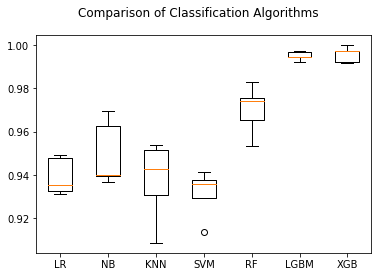

In [8]:
# Importing libraries
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Preparing models
models = []
models.append(('LR', LogisticRegression()))
models.append(('NB', GaussianNB()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', SVC()))
models.append(('RF', RandomForestClassifier()))
models.append(('LGBM', lgb.sklearn.LGBMClassifier()))
models.append(('XGB', xgb.XGBClassifier()))

# Model Evaluation
results = []
names = []

for name, model in models:
    kfold = model_selection.KFold(n_splits=K_FOLDS, random_state=K_FOLD_RANDOM_SEED)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=f1_scorer)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot to compare algorithms
fig = plt.figure()
fig.suptitle('Comparison of Classification Algorithms')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Refinement

In this section, you will need to discuss the process of improvement you made upon the algorithms and techniques you used in your implementation. For example, adjusting parameters for certain models to acquire improved solutions would fall under the refinement category. Your initial and final solutions should be reported, as well as any significant intermediate results as necessary. Questions to ask yourself when writing this section:
- _Has an initial solution been found and clearly reported?_
- _Is the process of improvement clearly documented, such as what techniques were used?_
- _Are intermediate and final solutions clearly reported as the process is improved?_


#### Hyper Parameter Grid Search

## 4. Results

### Model Evaluation and Validation

In this section, the final model and any supporting qualities should be evaluated in detail. It should be clear how the final model was derived and why this model was chosen. In addition, some type of analysis should be used to validate the robustness of this model and its solution, such as manipulating the input data or environment to see how the model’s solution is affected (this is called sensitivity analysis). Questions to ask yourself when writing this section:
- _Is the final model reasonable and aligning with solution expectations? Are the final parameters of the model appropriate?_
- _Has the final model been tested with various inputs to evaluate whether the model generalizes well to unseen data?_
- _Is the model robust enough for the problem? Do small perturbations (changes) in training data or the input space greatly affect the results?_
- _Can results found from the model be trusted?_


### Jusitifcation

In this section, your model’s final solution and its results should be compared to the benchmark you established earlier in the project using some type of statistical analysis. You should also justify whether these results and the solution are significant enough to have solved the problem posed in the project. Questions to ask yourself when writing this section:
- _Are the final results found stronger than the benchmark result reported earlier?_
- _Have you thoroughly analyzed and discussed the final solution?_
- _Is the final solution significant enough to have solved the problem?_


## 5. Conclusion

### Free-Form Visualization

In this section, you will need to provide some form of visualization that emphasizes an important quality about the project. It is much more free-form, but should reasonably support a significant result or characteristic about the problem that you want to discuss. Questions to ask yourself when writing this section:
- _Have you visualized a relevant or important quality about the problem, dataset, input data, or results?_
- _Is the visualization thoroughly analyzed and discussed?_
- _If a plot is provided, are the axes, title, and datum clearly defined?_


### Reflection

In this section, you will summarize the entire end-to-end problem solution and discuss one or two particular aspects of the project you found interesting or difficult. You are expected to reflect on the project as a whole to show that you have a firm understanding of the entire process employed in your work. Questions to ask yourself when writing this section:
- _Have you thoroughly summarized the entire process you used for this project?_
- _Were there any interesting aspects of the project?_
- _Were there any difficult aspects of the project?_
- _Does the final model and solution fit your expectations for the problem, and should it be used in a general setting to solve these types of problems?_


### Improvement

In this section, you will need to provide discussion as to how one aspect of the implementation you designed could be improved. As an example, consider ways your implementation can be made more general, and what would need to be modified. You do not need to make this improvement, but the potential solutions resulting from these changes are considered and compared/contrasted to your current solution. Questions to ask yourself when writing this section:
- _Are there further improvements that could be made on the algorithms or techniques you used in this project?_
- _Were there algorithms or techniques you researched that you did not know how to implement, but would consider using if you knew how?_
- _If you used your final solution as the new benchmark, do you think an even better solution exists?_


--------------------------------------------------------------------------

**Before submitting, ask yourself. . .**

- Does the project report you’ve written follow a well-organized structure similar to that of the project template?
- Is each section (particularly **Analysis** and **Methodology**) written in a clear, concise and specific fashion? Are there any ambiguous terms or phrases that need clarification?
- Would the intended audience of your project be able to understand your analysis, methods, and results?
- Have you properly proof-read your project report to assure there are minimal grammatical and spelling mistakes?
- Are all the resources used for this project correctly cited and referenced?
- Is the code that implements your solution easily readable and properly commented?
- Does the code execute without error and produce results similar to those reported?
